In [1]:
import sys
sys.path.append("..")

In [2]:
from circuits.circuits import Separable_rx, IQPLikeCircuit

from models.concentration_bounds import A_expressibility, haar_frame_potential, subspace_dimension
from squlearn.kernel import ProjectedQuantumKernel, FidelityKernel
from qiskit.primitives import Estimator, Sampler
from squlearn.util import Executor
import numpy as np
from models.manual_kernels import *
from data_tools.tools import  *


import seaborn as sns
import matplotlib.pyplot as plt


from matplotlib import rc
rc('text', usetex=True)
plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
    })

sns.set_context("paper", rc={"font.size":14,"axes.titlesize":16,"axes.labelsize":16, 
                             "legend.fontsize":14, "xtick.labelsize":16, 
                             "ytick.labelsize":16, "legend.title_fontsize":14,  'lines.linewidth': 3, 'lines.markersize': 6})

import matplotlib.patches as mpatches



squlearn.encoding_circuit.__init__.py running


In [3]:
top_eigenvalue_str = r"$\eta_{max}$"
varK_diagonal_str = "Var $K$"
expressibility_label = r"Expressibility $\epsilon_{\mathcal{U}_{\mathcal{X}}}$"

kernel_type_str = "Kernel "
num_qubit_str = "$\#$ dimensions $n$"
performance_str = "roc auc score"
top_eigenvalue_str = r"$\eta_{\mathrm{max}}$"
frobenius_str = r"$F(\mathbf{K}_{\mathrm{C}}, \mathbf{K}_{\mathrm{Q}})$"
g_str = r"$g(\mathbf{K}_{\mathrm{C}}, \mathbf{K}_{\mathrm{Q}})$"
bandwidth_str = "bandwidth $c^*$"
varK_str = r"Var$_{\mathcal{D}}[\mathbf{K}]$"
expressibility_label = r"$\epsilon_{\mathbb{U}_{\mathcal{X}}}$"
num_layers_str = "$\#$ layers $L$"

categories_to_plot = [varK_str, top_eigenvalue_str, expressibility_label]


def varK_analytical(c, num_qubits, num_layers):
    c = c*num_layers
    EKXY = 1/2 - np.cos(2*np.pi*c)/(4*np.pi**2*c**2) + 1/(4*np.pi**2*c**2)
    EKXYsquare = 3/8 - np.cos(2*np.pi*c)/(4*np.pi**2*c**2) - np.cos(4*np.pi*c)/(64*np.pi**2*c**2) + 17/(64*np.pi**2*c**2)
    
    return EKXYsquare**num_qubits - (EKXY**(2*num_qubits))
    
def varK_analytical_limits(c, num_qubits, num_layers, limit="small"):
    c = c*num_layers
    if limit == "large":
        #(-2**(5*n_{qubits}) + 2**(4*n_{qubits})*3**n_{qubits})/2**(7*n_{qubits})
        return (-2**(5*num_qubits) + 2**(4*num_qubits)*3**num_qubits)/2**(7*num_qubits)
    elif limit == "small":
        #7*pi**4*c**4*n_{qubits}/180
        return 7*np.pi**4*c**4*num_qubits/180
    
def expressibility_analytical(c, num_qubits, num_layers):
    #1/2 - cos(2*pi*c)/(4*pi**2*c**2) + 1/(4*pi**2*c**2)
    c = c*num_layers
    #3/8 - cos(2*pi*c)/(4*pi**2*c**2) - cos(4*pi*c)/(64*pi**2*c**2) + 17/(64*pi**2*c**2)
    E2kXY = 3/8 - np.cos(2*np.pi*c)/(4*np.pi**2*c**2) - np.cos(4*np.pi*c)/(64*np.pi**2*c**2) + 17/(64*np.pi**2*c**2)
    return np.sqrt(E2kXY**num_qubits - haar_frame_potential(2, 2**num_qubits))
def expressibility_analytical_limits(c, num_qubits, num_layers, limit="small"):
    c = c*num_layers
    if limit == "large":
        return np.sqrt((3/8)**num_qubits - haar_frame_potential(2, 2**num_qubits))
    elif limit == "small":
        return np.sqrt(1 - haar_frame_potential(2, 2**num_qubits))
    
def eta_max_analytical(c, num_qubits, num_layers):
    c = c*num_layers
    return ((6*np.pi*c + np.sqrt(4*np.pi**2*c**2 - 4*np.pi*c*np.sin(2*np.pi*c) + np.sin(2*np.pi*c)**2 - 32*np.cos(2*np.pi*c) + 32) + np.sin(2*np.pi*c))/(16*np.pi*c))**num_qubits

def eta_max_analytical_limits(c, num_qubits, num_layers, limit="small"):
    c = c*num_layers
    if limit == "large":
        return (1/2)**num_qubits
    elif limit == "small":
        return 1
    

def local_preprocess(path_extension):
    kernels_layers = pd.DataFrame(read_experiment_dic_results(f"../data/results/kernels_{path_extension}.h5", ignore_Ks=False, short_load=False))
    kernels_layers_ = kernels_layers.copy()
    

    kernels_layers_[bandwidth_str] = kernels_layers_["bandwidth"]
    kernels_layers_[num_qubit_str] = kernels_layers_["num_qubits"]
    kernels_layers_[num_layers_str] = kernels_layers_["num_layers"]
    #make num_layers_str a categorical variable
    #kernels_layers_[num_layers_str] = kernels_layers_[num_layers_str].astype("category")
    #kernels_layers_["num_layers"] = kernels_layers_["num_layers"].astype("category")


    kernels_layers_[expressibility_label] = kernels_layers_.apply(lambda row: A_expressibility(row["K_train"], row["num_qubits"], t=2), axis=1)
    kernels_layers_[varK_str] = kernels_layers_["K_train"].apply(lambda K: np.var(K.flatten()))
    kernels_layers_[top_eigenvalue_str] = kernels_layers_["eigenvalues"].apply(lambda x: np.max(x))

    

    #create a figure with 3 subplots
    kernels_layers_dummy = kernels_layers_.copy()
    kernels_layers_top = kernels_layers_.copy()
    kernels_layers_top = kernels_layers_top.sort_values(varK_str, ascending=False).drop_duplicates(["num_layers", "num_qubits", "seed"])
    #aggregate kernels_layers_top over seed and bandwidth
    kernels_layers_top_aggregated = kernels_layers_top.groupby(["num_layers", "num_qubits"]).mean(numeric_only=True).reset_index()


    
    kernels = kernels_layers_.copy()

    kernels["varK_analytical"] = kernels.apply(lambda x: varK_analytical(x["bandwidth"], x["num_qubits"], x["num_layers"]), axis=1)
    kernels["varK_analytical_small"] = kernels.apply(lambda x: varK_analytical_limits(x["bandwidth"], x["num_qubits"], x["num_layers"], "small"), axis=1)
    kernels["varK_analytical_large"] = kernels.apply(lambda x: varK_analytical_limits(x["bandwidth"], x["num_qubits"], x["num_layers"], "large"), axis=1)

    kernels["expressibility_analytical"] = kernels.apply(lambda x: expressibility_analytical(x["bandwidth"], x["num_qubits"], x["num_layers"]), axis=1)
    kernels["expressibility_analytical_small"] = kernels.apply(lambda x: expressibility_analytical_limits(x["bandwidth"], x["num_qubits"], x["num_layers"], "small"), axis=1)
    kernels["expressibility_analytical_large"] = kernels.apply(lambda x: expressibility_analytical_limits(x["bandwidth"], x["num_qubits"], x["num_layers"], "large"), axis=1)

    kernels["eta_max_analytical"] = kernels.apply(lambda x: eta_max_analytical(x["bandwidth"], x["num_qubits"], x["num_layers"]), axis=1)
    kernels["eta_max_analytical_small"] = kernels.apply(lambda x: eta_max_analytical_limits(x["bandwidth"], x["num_qubits"], x["num_layers"], "small"), axis=1)
    kernels["eta_max_analytical_large"] = kernels.apply(lambda x: eta_max_analytical_limits(x["bandwidth"], x["num_qubits"], x["num_layers"], "large"), axis=1)

    #A_expressibility(K, n_qubits, t=2)
    kernels["varK_numerical"] = kernels.apply(lambda x: np.var(x["K_train"]), axis=1)
    kernels["expressibility_numerical"] = kernels.apply(lambda x: A_expressibility(x["K_train"], x["num_qubits"], t=2), axis=1)
    kernels["eta_max_numerical"] = kernels.apply(lambda x: np.max(x["eigenvalues"]), axis=1)

    return kernels, kernels_layers_top_aggregated, kernels_layers_dummy




def analytical_quantities(kernels): 
    kernels["varK_analytical"] = kernels.apply(lambda x: varK_analytical(x["bandwidth"], x["num_qubits"], x["num_layers"]), axis=1)
    kernels["varK_analytical_small"] = kernels.apply(lambda x: varK_analytical_limits(x["bandwidth"], x["num_qubits"], x["num_layers"], "small"), axis=1)
    kernels["varK_analytical_large"] = kernels.apply(lambda x: varK_analytical_limits(x["bandwidth"], x["num_qubits"], x["num_layers"], "large"), axis=1)

    kernels["expressibility_analytical"] = kernels.apply(lambda x: expressibility_analytical(x["bandwidth"], x["num_qubits"], x["num_layers"]), axis=1)
    kernels["expressibility_analytical_small"] = kernels.apply(lambda x: expressibility_analytical_limits(x["bandwidth"], x["num_qubits"], x["num_layers"], "small"), axis=1)
    kernels["expressibility_analytical_large"] = kernels.apply(lambda x: expressibility_analytical_limits(x["bandwidth"], x["num_qubits"], x["num_layers"], "large"), axis=1)

    kernels["eta_max_analytical"] = kernels.apply(lambda x: eta_max_analytical(x["bandwidth"], x["num_qubits"], x["num_layers"]), axis=1)
    kernels["eta_max_analytical_small"] = kernels.apply(lambda x: eta_max_analytical_limits(x["bandwidth"], x["num_qubits"], x["num_layers"], "small"), axis=1)
    kernels["eta_max_analytical_large"] = kernels.apply(lambda x: eta_max_analytical_limits(x["bandwidth"], x["num_qubits"], x["num_layers"], "large"), axis=1)

    #A_expressibility(K, n_qubits, t=2)
    # kernels["varK_numerical"] = kernels.apply(lambda x: np.var(x["K_train"]), axis=1)
    # kernels["expressibility_numerical"] = kernels.apply(lambda x: A_expressibility(x["K_train"], x["num_qubits"], t=2), axis=1)
    # kernels["eta_max_numerical"] = kernels.apply(lambda x: np.max(x["eigenvalues"]), axis=1)
    return kernels





[16, 1, 2, 8, 4]
Categories (9, int64): [1, 2, 4, 6, ..., 10, 12, 14, 16]
[16, 1, 2, 8, 4]
Categories (9, int64): [1, 2, 4, 6, ..., 10, 12, 14, 16]
[16, 1, 2, 8, 4]
Categories (9, int64): [1, 2, 4, 6, ..., 10, 12, 14, 16]


C:\Users\jsl-rf\AppData\Local\Temp\ipykernel_15616\198330488.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kernels["varK_analytical"] = kernels.apply(lambda x: varK_analytical(x["bandwidth"], x["num_qubits"], x["num_layers"]), axis=1)
C:\Users\jsl-rf\AppData\Local\Temp\ipykernel_15616\198330488.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kernels["varK_analytical_small"] = kernels.apply(lambda x: varK_analytical_limits(x["bandwidth"], x["num_qubits"], x["num_layers"], "small"), axis=1)
C:\U

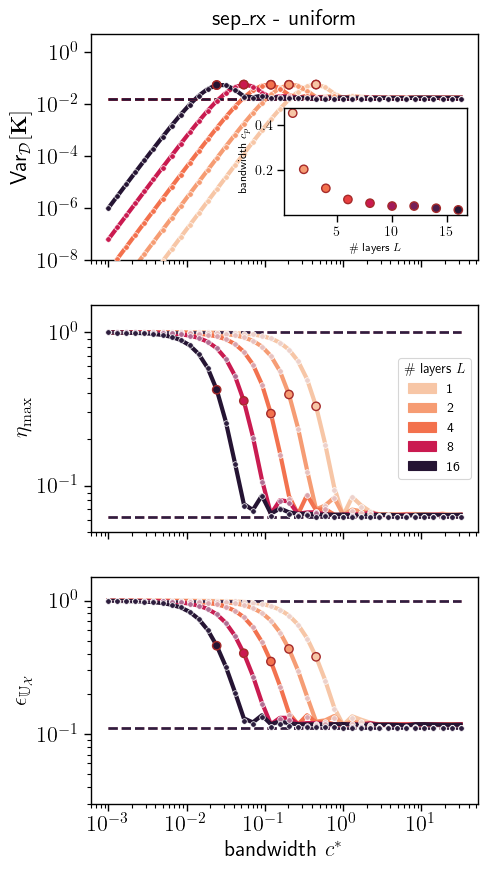

[1, 4, 8, 16, 2]
Categories (9, int32): [1, 2, 4, 6, ..., 10, 12, 14, 16]
[1, 4, 8, 16, 2]
Categories (9, int32): [1, 2, 4, 6, ..., 10, 12, 14, 16]
[1, 4, 8, 16, 2]
Categories (9, int32): [1, 2, 4, 6, ..., 10, 12, 14, 16]


C:\Users\jsl-rf\AppData\Local\Temp\ipykernel_15616\198330488.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kernels["varK_analytical"] = kernels.apply(lambda x: varK_analytical(x["bandwidth"], x["num_qubits"], x["num_layers"]), axis=1)
C:\Users\jsl-rf\AppData\Local\Temp\ipykernel_15616\198330488.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kernels["varK_analytical_small"] = kernels.apply(lambda x: varK_analytical_limits(x["bandwidth"], x["num_qubits"], x["num_layers"], "small"), axis=1)
C:\U

<Figure size 640x480 with 0 Axes>

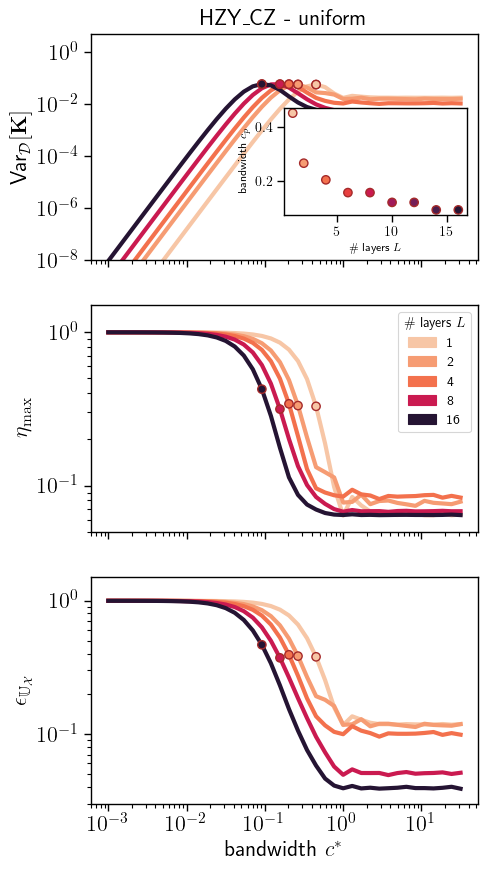

[1, 4, 8, 16, 2]
Categories (9, int32): [1, 2, 4, 6, ..., 10, 12, 14, 16]
[1, 4, 8, 16, 2]
Categories (9, int32): [1, 2, 4, 6, ..., 10, 12, 14, 16]
[1, 4, 8, 16, 2]
Categories (9, int32): [1, 2, 4, 6, ..., 10, 12, 14, 16]


C:\Users\jsl-rf\AppData\Local\Temp\ipykernel_15616\198330488.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kernels["varK_analytical"] = kernels.apply(lambda x: varK_analytical(x["bandwidth"], x["num_qubits"], x["num_layers"]), axis=1)
C:\Users\jsl-rf\AppData\Local\Temp\ipykernel_15616\198330488.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kernels["varK_analytical_small"] = kernels.apply(lambda x: varK_analytical_limits(x["bandwidth"], x["num_qubits"], x["num_layers"], "small"), axis=1)
C:\U

<Figure size 640x480 with 0 Axes>

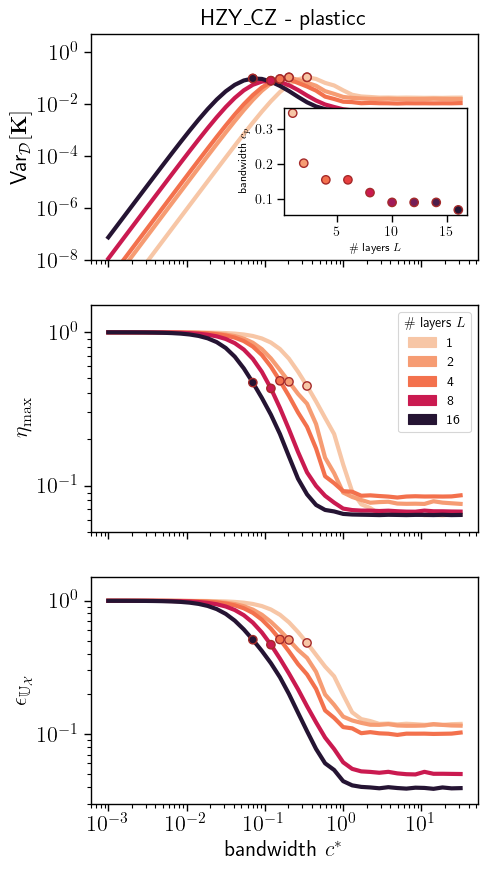

[16, 1, 2, 8, 4]
Categories (9, int64): [1, 2, 4, 6, ..., 10, 12, 14, 16]
[16, 1, 2, 8, 4]
Categories (9, int64): [1, 2, 4, 6, ..., 10, 12, 14, 16]
[16, 1, 2, 8, 4]
Categories (9, int64): [1, 2, 4, 6, ..., 10, 12, 14, 16]


C:\Users\jsl-rf\AppData\Local\Temp\ipykernel_15616\198330488.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kernels["varK_analytical"] = kernels.apply(lambda x: varK_analytical(x["bandwidth"], x["num_qubits"], x["num_layers"]), axis=1)
C:\Users\jsl-rf\AppData\Local\Temp\ipykernel_15616\198330488.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kernels["varK_analytical_small"] = kernels.apply(lambda x: varK_analytical_limits(x["bandwidth"], x["num_qubits"], x["num_layers"], "small"), axis=1)
C:\U

<Figure size 640x480 with 0 Axes>

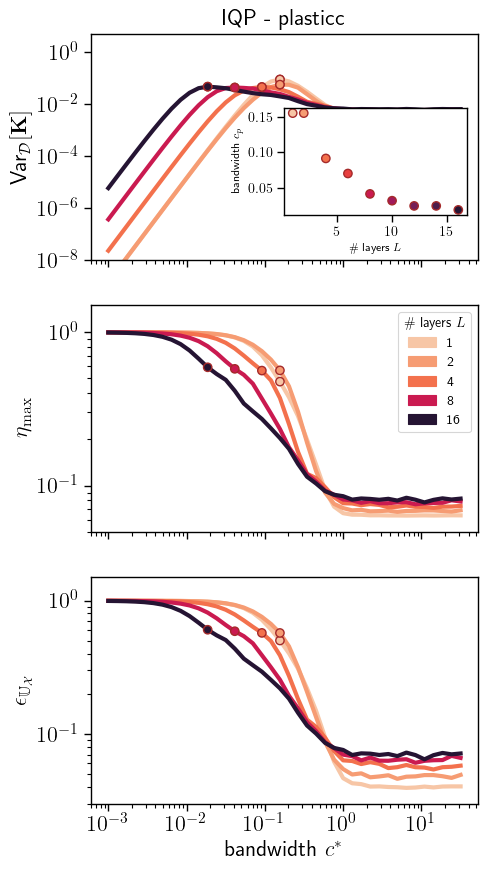

[1, 4, 8, 16, 2]
Categories (9, int32): [1, 2, 4, 6, ..., 10, 12, 14, 16]
[1, 4, 8, 16, 2]
Categories (9, int32): [1, 2, 4, 6, ..., 10, 12, 14, 16]
[1, 4, 8, 16, 2]
Categories (9, int32): [1, 2, 4, 6, ..., 10, 12, 14, 16]


C:\Users\jsl-rf\AppData\Local\Temp\ipykernel_15616\198330488.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kernels["varK_analytical"] = kernels.apply(lambda x: varK_analytical(x["bandwidth"], x["num_qubits"], x["num_layers"]), axis=1)
C:\Users\jsl-rf\AppData\Local\Temp\ipykernel_15616\198330488.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kernels["varK_analytical_small"] = kernels.apply(lambda x: varK_analytical_limits(x["bandwidth"], x["num_qubits"], x["num_layers"], "small"), axis=1)
C:\U

<Figure size 640x480 with 0 Axes>

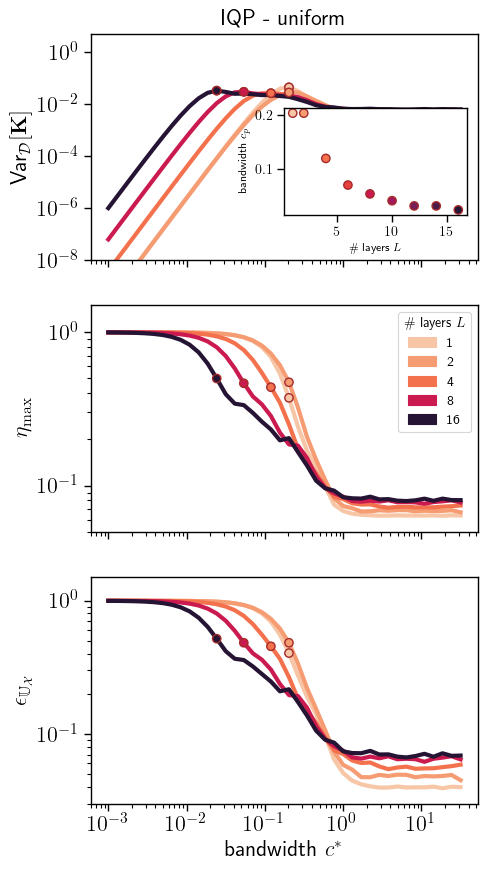

[1, 4, 8, 16, 2]
Categories (9, int32): [1, 2, 4, 6, ..., 10, 12, 14, 16]
[1, 4, 8, 16, 2]
Categories (9, int32): [1, 2, 4, 6, ..., 10, 12, 14, 16]
[1, 4, 8, 16, 2]
Categories (9, int32): [1, 2, 4, 6, ..., 10, 12, 14, 16]


C:\Users\jsl-rf\AppData\Local\Temp\ipykernel_15616\198330488.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kernels["varK_analytical"] = kernels.apply(lambda x: varK_analytical(x["bandwidth"], x["num_qubits"], x["num_layers"]), axis=1)
C:\Users\jsl-rf\AppData\Local\Temp\ipykernel_15616\198330488.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kernels["varK_analytical_small"] = kernels.apply(lambda x: varK_analytical_limits(x["bandwidth"], x["num_qubits"], x["num_layers"], "small"), axis=1)
C:\U

<Figure size 640x480 with 0 Axes>

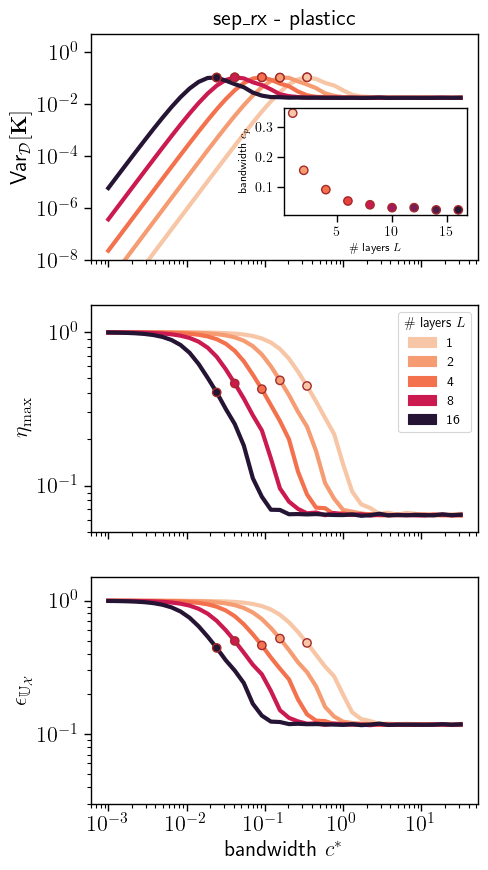

<Figure size 640x480 with 0 Axes>

In [ ]:


def preprocess_and_plot(path_extension, title_plot):
    kernels, kernels_layers_top_aggregated, kernels_layers_dummy = local_preprocess(path_extension)

    #make num_layers_str a categorical variable
    kernels_layers_dummy[num_layers_str] = kernels_layers_dummy[num_layers_str].astype("category")
    kernels_layers_top_aggregated[num_layers_str] = kernels_layers_top_aggregated[num_layers_str].astype("category")
    #use magma colormap
    palette = sns.color_palette("rocket_r", n_colors=len(kernels_layers_dummy[num_layers_str].unique()))
    #transform the palette to a dictionary associating the num_layers to the color
    palette = dict(zip(np.sort(kernels_layers_dummy[num_layers_str].unique()), palette))


    fig, axs = plt.subplots(3, 1, figsize=(5, 10), sharex=True)

    #only keep if num_layers is in [1, 2,4, 8, 16]
    layers_to_keep = [1, 2, 4, 8, 16]


    kernels_layers_cut_layers = kernels_layers_dummy[kernels_layers_dummy[num_layers_str].isin(layers_to_keep)]
    kernels_layers_cut_layers_top_aggregated = kernels_layers_top_aggregated[kernels_layers_top_aggregated[num_layers_str].isin(layers_to_keep)]


    for i, category in enumerate(categories_to_plot):
        legend_ = True if i == 1 else False
        print(kernels_layers_cut_layers[num_layers_str].unique())
        sns.lineplot(data=kernels_layers_cut_layers, x=bandwidth_str, y=category, hue=num_layers_str,  ax=axs[i], legend=legend_, palette=palette)
        #if i == 0, create and inset plot: sns.boxplot(data=kernels_layers_dummy, x="num_layers", y="bandwidth", hue="num_layers",  ax=axs[1], native_scale=False,orient="v", width=1)
        sns.scatterplot(data=kernels_layers_cut_layers_top_aggregated, x=bandwidth_str, y=category, hue=num_layers_str, ax=axs[i], legend=False, linewidth=1, zorder=15, edgecolor="brown", palette=palette)
        if i == 0:
            inset_ax = axs[i].inset_axes([0.5, 0.2, 0.47, 0.47])

            #sns.boxplot(data=kernels_layers_top_aggregated, x="bandwidth", y="num_layers", hue="num_layers", ax=inset_ax, orient="v", legend=False, native_scale=True)
            
            sns.scatterplot(data=kernels_layers_cut_layers_top_aggregated, x=bandwidth_str, y=category, hue=num_layers_str, ax=axs[i], legend=False, linewidth=1, zorder=10, edgecolor="brown", palette=palette)
            sns.scatterplot(data=kernels_layers_top_aggregated, x=num_layers_str, y=bandwidth_str, hue=num_layers_str, ax=inset_ax, linewidth=1, legend=False, edgecolor="brown", palette=palette)
            
            #reduce the size of x and y ticks font
            # inset_ax.set_xticks(inset_ax.get_xticks())
            # inset_ax.set_xticklabels(inset_ax.get_xticklabels(), fontsize=8)

            inset_ax.tick_params(axis='both', which='major', labelsize=10)
            inset_ax.tick_params(axis='both', which='minor', labelsize=8)
            
            inset_ax.set_xlabel(num_layers_str, fontsize=8)
            inset_ax.set_ylabel("bandwidth $c_p$", fontsize=8)
        
        #if legend true, use 2 columns
        if legend_:
            
            axs[i].legend(loc='best',  ncol=2, fontsize=10)
            axs[i].legend_.set_title(num_layers_str, prop={'size':10})
            #inset_ax.set_xscale("log")
            #inset_ax.set_xscale("log")
            
        axs[i].set_xscale("log")
        axs[i].set_yscale("log")

    linewidth_size = 5
    intermediate_linewidth_size = 1.8
    thinlinewidth_size = 0.05
    scatter_size = 12
    marker_size = 4
    marker_edge_width = 0.5
    kernels_nq = kernels_layers_cut_layers.copy()
    kernels_nq = analytical_quantities(kernels_layers_cut_layers)

    selected_palette = palette


    if path_extension == "0_67":
        numerical_str = "Numerical"
        analytical_str = "Analytical"
        small_str = r"$c \rightarrow 0$"
        large_str = r"$c \rightarrow \infty$"

        ax = axs[0]
        sns.lineplot(data=kernels_nq, x="bandwidth", y="varK_analytical", ax=ax, zorder=3, hue="num_layers", palette = selected_palette, legend=False, marker="o",  linewidth=thinlinewidth_size, markersize=marker_size, markeredgewidth=0.5)
        #sns.lineplot(data=kernels_nq, x="bandwidth", y="varK_train", ax=ax, linestyle='-', linewidth=linewidth_size, hue="num_layers", palette = selected_palette, legend=False)
        #sns.lineplot(data=kernels_nq, x="bandwidth", y="VarK_fit_flat", ax=ax, linewidth=linewidth_size,linestyle='-.', hue="num_qubits", palette = selected_palette)
        sns.lineplot(data=kernels_nq, x="bandwidth", y="varK_analytical_large", ax=ax, linestyle='--', palette = selected_palette, legend=False, hue="num_layers", linewidth=intermediate_linewidth_size)


        ax = axs[1]
        sns.lineplot(data=kernels_nq, x="bandwidth", y="eta_max_analytical", hue="num_layers", ax=ax, zorder=10, marker="o",  linewidth=thinlinewidth_size, markersize=marker_size, markeredgewidth=marker_edge_width)
        sns.lineplot(data=kernels_nq, x="bandwidth", y="eta_max_analytical_small",  hue="num_layers", ax=ax, linestyle='--', linewidth=intermediate_linewidth_size)
        sns.lineplot(data=kernels_nq, x="bandwidth", y="eta_max_analytical_large", hue="num_layers", ax=ax,  linestyle='--', linewidth=intermediate_linewidth_size)
        #sns.lineplot(data=kernels_nq, x="bandwidth", y=top_eigenvalue_str, hue="num_layers", ax=ax,  palette = selected_palette, linewidth = linewidth_size, linestyle='-' )
        ax.get_legend().remove()


        ax = axs[2]
        sns.lineplot(data=kernels_nq, x="bandwidth", y="expressibility_analytical", hue="num_layers", ax=ax, zorder=10, marker="o",  linewidth=thinlinewidth_size, markersize=marker_size, markeredgewidth=marker_edge_width)
        sns.lineplot(data=kernels_nq, x="bandwidth", y="expressibility_analytical_small", hue="num_layers", ax=ax, linestyle='--', linewidth=intermediate_linewidth_size)
        sns.lineplot(data=kernels_nq, x="bandwidth", y="expressibility_analytical_large", hue="num_layers", ax=ax,  linestyle='--', linewidth=intermediate_linewidth_size)
        #sns.lineplot(data=kernels_nq, x="bandwidth", y=expressibility_label, hue="num_layers", ax=ax,  palette = selected_palette, linewidth = linewidth_size, linestyle='-' )
        ax.get_legend().remove()


    axs[0].set_ylim(1e-8, 5*1e0)
    axs[1].set_ylim(0.5*10**(-1), 1.5)
    axs[2].set_ylim(0.3*10**(-1), 1.5)


    manual_patches = []
    for label, color in palette.items():
        if label in layers_to_keep:
            manual_patches.append(mpatches.Patch(color=color, label=label))

    axs[1].legend(handles=manual_patches, labels=layers_to_keep, loc='best', title=num_layers_str, fontsize=10, title_fontsize=10)

    axs[0].set_title(title_plot)

    plt.savefig(f"../data/plots/layers_{title_plot}_layers.pdf", bbox_inches='tight')
    plt.show()
    #remove ylabels and save again
    for ax in axs:
        ax.set_ylabel("")
        ax.set_yticklabels([])

    plt.savefig(f"../data/plots/layers_{title_plot}_layers_no_ylabel.pdf", bbox_inches='tight')




path_extension, title_plot = "0_67", "sep_rx - uniform"
preprocess_and_plot(path_extension, title_plot)

path_extension, title_plot = "0_69", "sep_rx - plasticc"
preprocess_and_plot(path_extension, title_plot)

path_extension, title_plot = "0_70", "HZY_CZ - uniform"
preprocess_and_plot(path_extension, title_plot)

path_extension, title_plot = "0_71", "HZY_CZ - plasticc"
preprocess_and_plot(path_extension, title_plot)

path_extension, title_plot = "0_66", "IQP - plasticc"
preprocess_and_plot(path_extension, title_plot)

path_extension, title_plot = "0_68", "IQP - uniform"
preprocess_and_plot(path_extension, title_plot)
